In [1]:
# imports
from Utils.Imports import *
from Utils.ModelWrapper import ModelWrapper

# models
from Models.BuildEncoder import BuildEncoder
from Models.BuildDecoder import BuildDecoder

In [2]:
device = torch.device(GetLowestGPU())

Device set to cuda:2


# Generate samples using pre-trained VAE 

In [3]:
# VAE design parameters
latent_dim = 100
layers = [16, 32, 64, 128, 256]
image_shape = (1, 128, 128)
final_shape = int(image_shape[1] / (2**len(layers)))

# initialize VAE model
class VAE(nn.Module):
   
    def __init__(self):
        
        super().__init__()
        self.image_shape = image_shape
        encoder_input = list(image_shape)
        
        self.encoder = BuildEncoder(
            input_shape=encoder_input,
            latent_dim=2*latent_dim,
            layers=layers,
            activation=nn.ELU(),
            addl_convs=0,
            use_batchnorm=True)
        
        self.decoder = BuildDecoder(
            latent_dim=latent_dim,
            init_shape=[layers[-1], final_shape, final_shape],
            layers=layers[::-1],
            output_channels=image_shape[0],
            activation=nn.ELU(),
            addl_convs=0,
            use_batchnorm=True)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.device = device
        
    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        
        return z
    
    def encode(self, x):
        
        x = self.encoder(x).view(len(x), 2, -1)
        self.mu = x[:, 0, :]
        self.logvar = x[:, 1, :]
        
        return self.mu, self.logvar
    
    def forward(self, x):
        
        self.mu, self.logvar = self.encode(x)
        self.z = self.reparameterize(self.mu, self.logvar)
        reconstruction = self.decoder(self.z)
        reconstruction = self.sigmoid(reconstruction)
        
        return reconstruction

In [4]:
# instantiate model
vae = VAE().to(device)

# wrap model 
model = ModelWrapper(
    model=vae,
    optimizer=None,
    loss=None,
    regularizer=None,
    save_name='Weights/vae',
    save_best_train=False,
    save_best_val=True,
    save_opt=False)

# load model weights
model.load_best_val(device=device)

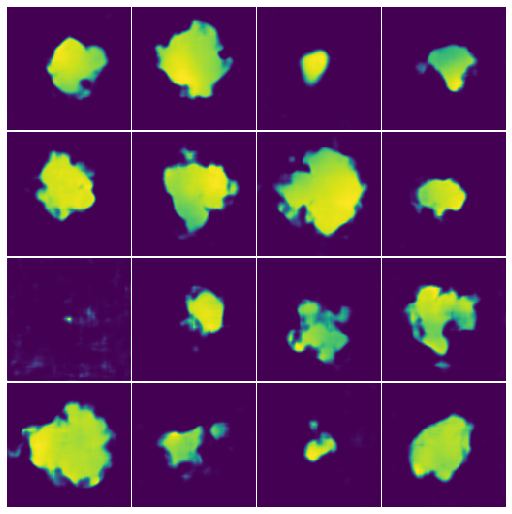

In [5]:
fig = plt.figure(figsize=(7,7))
for i in range(16):
    
    # draw random latent vector (1, 100)
    z = torch.tensor(np.random.normal(0, 1, [1, latent_dim])).float().to(device)
    
    # generate new sample (1, 1, 128, 128)
    sample = model.model.decoder(z).detach().cpu().numpy()
    
    # sigmoid
    sample = 1/(1+np.exp(-sample))
    
    # plot sample
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(np.squeeze(sample))
    plt.axis('off')
    
plt.tight_layout(pad=0.2)
plt.show()

# Generate samples using pre-trained GAN

In [6]:
# GAN design parameters 
latent_dim = 100
layers = [16, 32, 64, 128, 256]
image_shape = (1, 128, 128)
final_shape = int(image_shape[1] / (2**len(layers)))

# initialize generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = BuildDecoder(
            latent_dim=latent_dim,
            init_shape=[layers[-1], final_shape, final_shape],
            layers=layers[::-1],
            output_channels=image_shape[0],
            activation=nn.ReLU(),
            addl_convs=0,
            use_batchnorm=True)
        self.sigmoid = nn.Sigmoid()
    def forward(self, z):
        generated = self.generator(z)
        generated = self.sigmoid(generated)
        return generated

In [7]:
# instantiate model
G = Generator().to(device)

# load model weights
G.load_state_dict(torch.load('Weights/generator_weights'))

<All keys matched successfully>

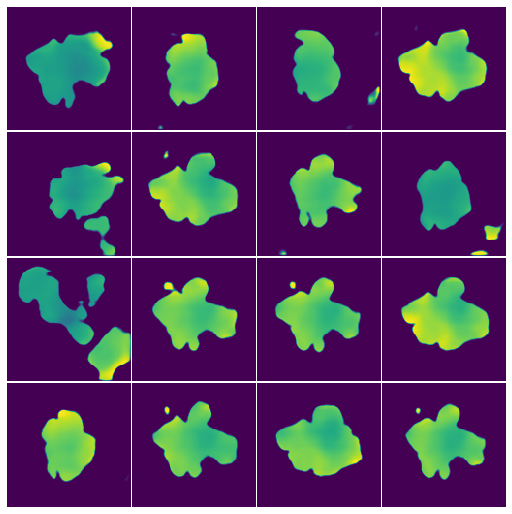

In [8]:
fig = plt.figure(figsize=(7,7))
for i in range(16):
    
    # draw random latent vector (1, 100)
    z = torch.tensor(np.random.normal(0, 1, [1, latent_dim])).float().to(device)
    
    # generate new sample (1, 1, 128, 128)
    sample = G(z).detach().cpu().numpy()
    
    # plot sample
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(np.squeeze(sample))
    plt.axis('off')
    
plt.tight_layout(pad=0.2)
plt.show()